In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, brier_score_loss
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns

plt.style.use("seaborn-v0_8")


sns.set(style="darkgrid")

# Load predictions
preds_dir = "artifacts/lightgbm_preds"

results = {}

for file in os.listdir(preds_dir):
    model_name = file.replace("_predictions.csv", "").capitalize()
    data = pd.read_csv(os.path.join(preds_dir, file))
    
    y_true = data["y_true"]
    y_pred = data["y_pred"]
    
    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    print(file, auc)
    
    # Precision-Recall Curve
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_pred)
    
    # Calibration (Brier Score Loss)
    brier = brier_score_loss(y_true, y_pred)
    
    # Store results
    results[model_name] = {
        "fpr": fpr, "tpr": tpr, "roc_auc": auc,
        "precision": precision, "recall": recall,
        "pr_thresholds": pr_thresholds,
        "brier": brier,
        "y_true": y_true, "y_pred": y_pred
    }


lightgbm_bce_continuous_predictions.csv 0.9780646061043194
lightgbm_focal_loss_continuous_predictions.csv 0.9798699799823338
lightgbm_rocstar_continuous_predictions.csv 0.9798699799823338


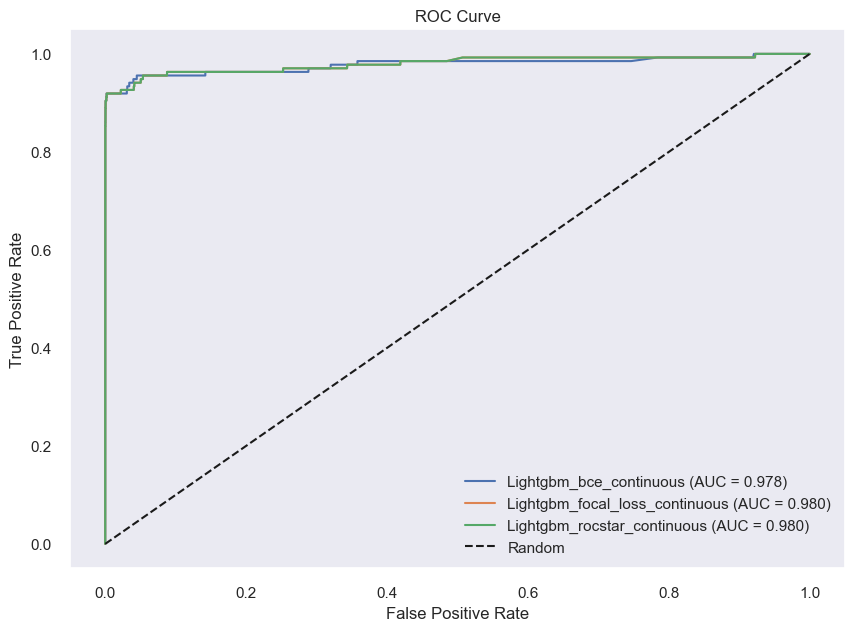

In [31]:
# 1. ROC Curve Plot
plt.figure(figsize=(10, 7))
for model_name, metrics in results.items():
    plt.plot(metrics["fpr"], metrics["tpr"], label=f'{model_name} (AUC = {metrics["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()



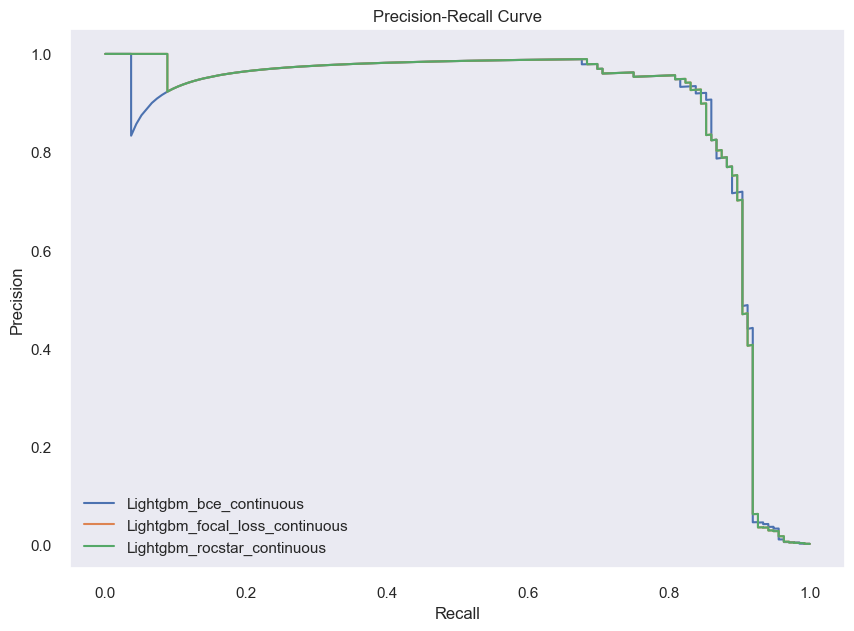

In [32]:
# 2. Precision-Recall Curve Plot
plt.figure(figsize=(10, 7))
for model_name, metrics in results.items():
    plt.plot(metrics["recall"], metrics["precision"], label=f'{model_name}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()



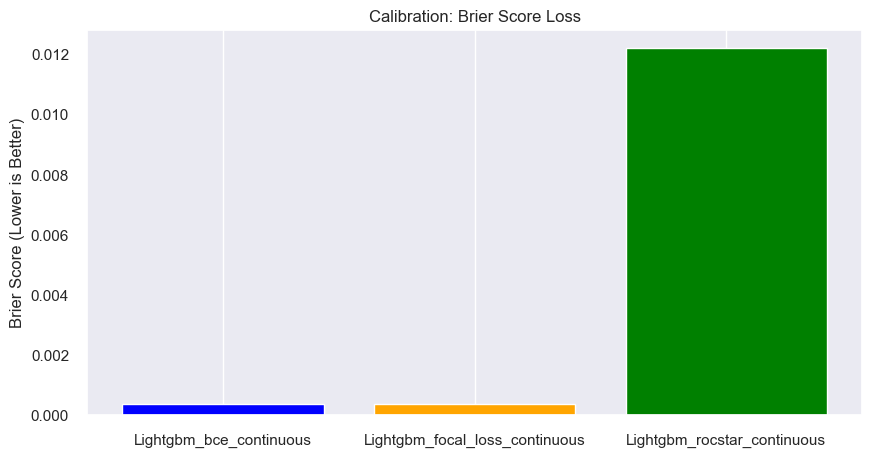

In [33]:
# 3. Calibration (Brier Score Loss)
model_names = list(results.keys())
brier_scores = [results[model]["brier"] for model in model_names]
plt.figure(figsize=(10, 5))
plt.bar(model_names, brier_scores, color=["blue", "orange", "green"])
plt.ylabel("Brier Score (Lower is Better)")
plt.title("Calibration: Brier Score Loss")
plt.grid(axis="y")
plt.show()



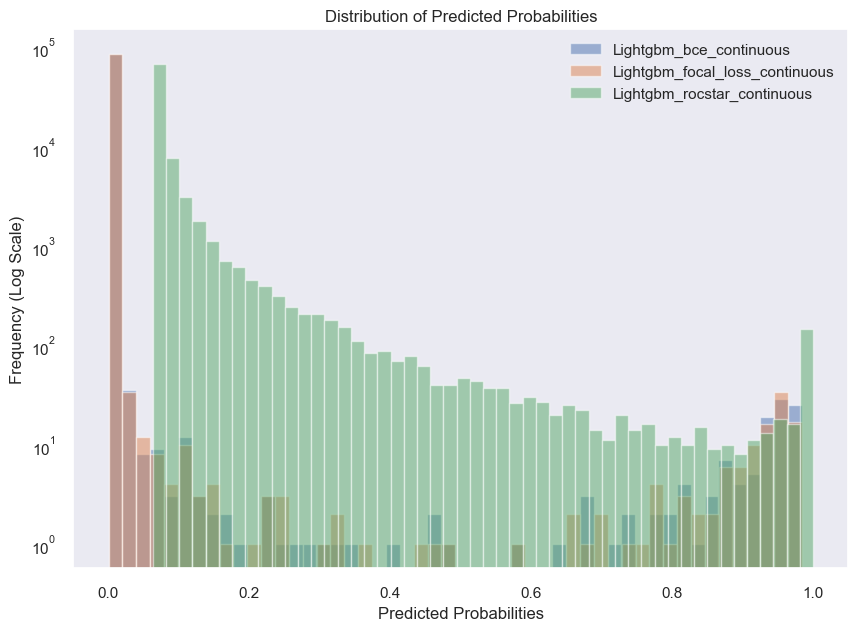

In [34]:
plt.figure(figsize=(10, 7))
for model_name, metrics in results.items():
    plt.hist(metrics["y_pred"], bins=50, alpha=0.5, label=model_name)
plt.xlabel("Predicted Probabilities")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Set y-axis to log scale
plt.title("Distribution of Predicted Probabilities")
plt.legend(loc="upper right")
plt.grid()
plt.show()


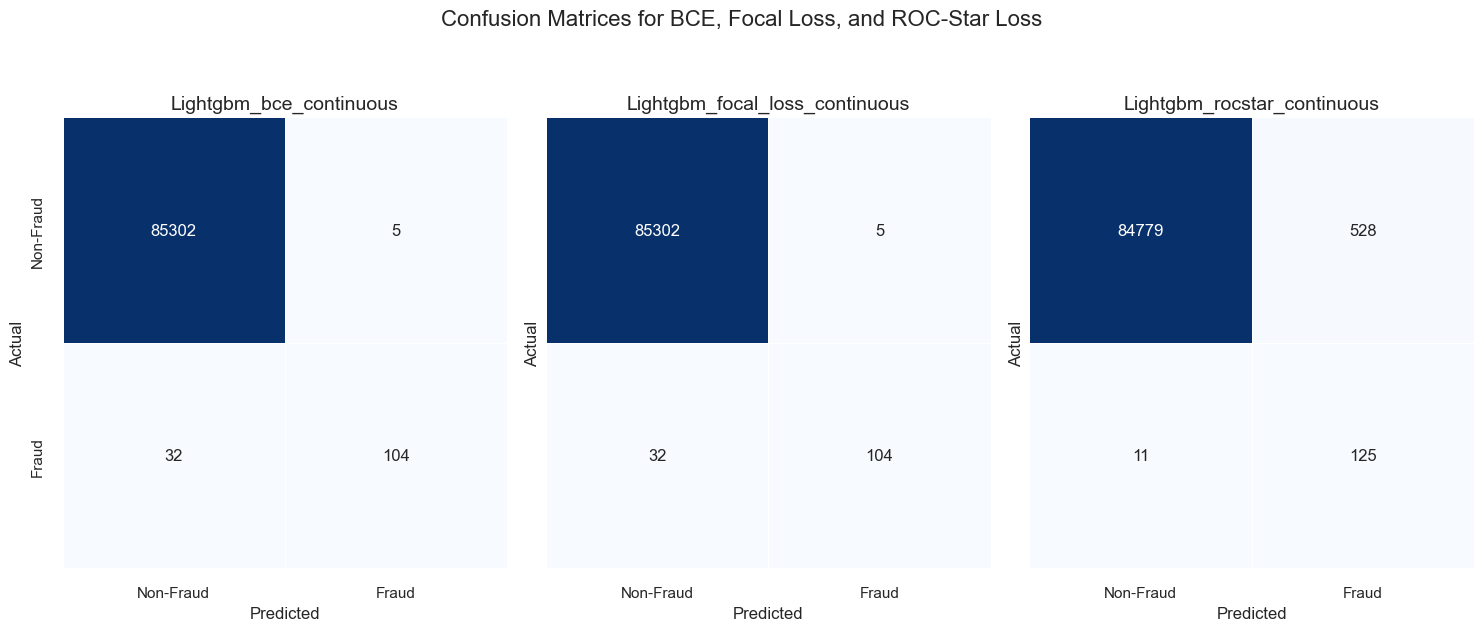

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Apply a minimalistic style
sns.set_style("whitegrid")

# Subplot for confusion matrices only
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# Loop through models to calculate and plot confusion matrices
for ax, (model_name, metrics) in zip(axes, results.items()):
    y_true = metrics["y_true"]
    y_pred_binary = (metrics["y_pred"] >= 0.5).astype(int)  # Adjust threshold if needed

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    
    # Plot confusion matrix using sns.heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Non-Fraud", "Fraud"],
        yticklabels=["Non-Fraud", "Fraud"],
        ax=ax,
        linewidths=0.5
    )
    ax.set_title(model_name, fontsize=14)
    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("Actual", fontsize=12)

# Set common title and adjust layout
fig.suptitle("Confusion Matrices for BCE, Focal Loss, and ROC-Star Loss", fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig('plots/confusion_matrices_lightgbm.png')
plt.show()
